In [1]:
from pathlib import Path
import numpy as np
import torch
import padertorch as pt
import padercontrib as pc
import paderbox as pb
from padertorch import Model
from sacred import Experiment, commands
from sklearn import metrics
from tqdm import tqdm
from paderbox.io.new_subdir import get_new_subdir
from paderbox.io import load_json, dump_json
from pprint import pprint
from fearless.sid.data import prepare_data
from fearless.sid.data import prepare_data_2
from scipy.special import softmax
from scipy.spatial.distance import euclidean as euc
from statistics import mean
import tensorflow as tf
import pb_sed.evaluation.instance_based as sed
import lazy_dataset
from padertorch.data.utils import collate_fn
from padertorch.ops.sequence.pack_module import pad_sequence
from padercontrib.database.fearless import Fearless
import padertorch as pt
import paderbox as pb
import numpy as np
import paderbox as pb
from padercontrib.database.iterator import AudioReader
from paderbox.transform import stft,fbank
import scipy
import pydub
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import pandas as pd
from pydub import AudioSegment
import torch
from padertorch.data.utils import collate_fn
import lazy_dataset
from padertorch.ops.sequence.pack_module import pad_sequence
import pandas
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from fearless.sid.data import prepare_data_3
from fearless.sid.data import prepare_data_4

In [3]:
import pyannote

from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate

# Dev Stream Dataset

In [4]:
db = Fearless()
dataset_Dev_str = db.get_dataset('Dev_stream')
df_Dev_str = pd.DataFrame(dataset_Dev_str)
df_Dev_str.head()

,audio_path,end,num_samples,num_speakers,speaker_id,start,transcription,example_id,dataset
0,{'observation': '/net/db/fearless/Audio/Stream...,"[1716960, 1724240, 1738480, 1742720, 1967600, ...",14816000,8,"[PROCEDURES1, FD1, PROCEDURES1, FD1, CONTROL1,...","[1710480, 1716960, 1724720, 1739440, 1955360, ...","[FLIGHT PROCEDURES., Go PROCEDURES., Upper clo...",FS02_dev_001,Dev_stream
1,{'observation': '/net/db/fearless/Audio/Stream...,"[24800, 128560, 143040, 164080, 172320, 206240...",14400000,30,"[EECOM3, TRACK0, MADRID, TRACK0, EECOM3, MADRI...","[16800, 123360, 140320, 148560, 164080, 176000...","[SPAN EECOM conference., MADRID TRACK., MADRID...",FS02_dev_002,Dev_stream
2,{'observation': '/net/db/fearless/Audio/Stream...,"[98400, 158960, 169680, 262480, 526720, 767200...",14400000,26,"[CAPCOM1, EMU, FD1, BUZZ, BUZZ, BUZZ, NEIL, BU...","[36320, 98400, 162720, 169680, 285840, 544480,...","[Uh roger BUZZ, and break break COLUMBIA this ...",FS02_dev_003,Dev_stream
3,{'observation': '/net/db/fearless/Audio/Stream...,"[748080, 760480, 770000, 802720, 826080, 88120...",14955294,11,"[RETRO1, FIDO1, RETRO1, UNK, FIDO1, RETRO1, FI...","[739600, 757520, 761920, 797040, 815840, 84056...","[FIDO this is RETRO., Go ahead., Did you get t...",FS02_dev_004,Dev_stream
4,{'observation': '/net/db/fearless/Audio/Stream...,"[28240, 102000, 146320, 182160, 258720, 376480...",14400000,14,"[CAPCOM1, BUZZ, CAPCOM1, BUZZ, CAPCOM1, BUZZ, ...","[0, 61920, 103840, 172560, 190080, 337840, 390...",[Is HOUSTON uh radio check and verify T.V. cir...,FS02_dev_005,Dev_stream


In [5]:
start = []
end = []
speaker_id = []
for index,row in df_Dev_str.iterrows():
    start.append(row['start'])
    end.append(row['end'])
    speaker_id.append(row['speaker_id'])

In [6]:
diary_new = diary = {'start':start,'end':end,'speaker_id':speaker_id}
df_new = pd.DataFrame(data=diary_new)

In [7]:
start_all = []
for i in start:
    for j in i:
        start_all.append(j)

end_all = []
for i in end:
    for j in i:
        end_all.append(j)
    
speaker_all = []
for i in speaker_id:
    for j in i:
        speaker_all.append(j)

In [8]:
diary = {'start':start_all,'end':end_all,'speaker_id':speaker_all}
df = pd.DataFrame(data=diary)

# SAD + SID Groundtruths

In [9]:
df

,start,end,speaker_id
0,1710480,1716960,PROCEDURES1
1,1716960,1724240,FD1
2,1724720,1738480,PROCEDURES1
3,1739440,1742720,FD1
4,1955360,1967600,CONTROL1
...,...,...,...
9198,14367680,14375360,NETWORK2
9199,14384560,14394560,FD1
9200,14394960,14397440,RECOVERY
9201,14417440,14422960,FD1


In [102]:
#exp_dir = '/net/vol/dheerajpr/models/SID/2021-09-05-22-42-44' #167  60.93
#exp_dir = '/net/vol/dheerajpr/models/SID/2021-09-09-20-08-35' #SID 59.08
#exp_dir = '/net/vol/dheerajpr/models/SID/2021-10-11-18-57-39' # SID (fbanks shift 160 to 180) 57.61
#ckpt_name = 'ckpt_126000.pth'
exp_dir = '/net/vol/dheerajpr/models/SID/2021-10-12-23-24-11' # SID logfbanks 56.788
ckpt_name = 'ckpt_best_loss.pth'

#exp_dir = '/net/vol/dheerajpr/models/SID/2021-10-15-21-17-48' # SID logfbanks (1 epoch validated) 57.54
#ckpt_name = 'ckpt_48280.pth'

device = 0
model_SID = Model.from_storage_dir(
    exp_dir, consider_mpi=True, checkpoint_name=ckpt_name
)
model_SID.to(device)
model_SID.eval()

ResNet_SID(
  size=ModelParameterSize(total_count=5388634, trainable_count=5388634, total_bytes=21554536, trainable_bytes=21554536)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool2d): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(

In [77]:
file_path = []
import os
path_all = '/net/vol/saadmann/dump_audio_test/'

for file in os.listdir(path_all):
    if file.endswith(".wav"):
        file_path.append(f"{path_all}{file}")
        
file_path_sorted = sorted(file_path)

In [78]:
sad_out = []
for i in file_path_sorted:
    sad_out.append(np.round(pb.io.load_audio(i)).astype(bool))

In [79]:
from paderbox.array import intervall
intervals_sad = []

for i in sad_out:
    intervals_sad.append(intervall.ArrayIntervall(i))

intervals_sad

[ArrayIntervall("1707680:1746960, 1952000:1971440, 2811040:3008000, 3014720:3022480, 3776000:3789200, 3793760:3847760, 4512000:4522480, 4529600:4590320, 4768000:4804720, 6611840:6625040, 6654560:6900880, 6903520:6945040, 7104000:7264000, 7633920:7684880, 7744000:7797840, 7807360:7808000, 10956640:11014160, 11341920:11353360, 11360000:11360720, 11368960:11402640, 12800000:12899920, 12983360:13067120, 13971520:14021680", shape=(14816000,)),
 ArrayIntervall("15360:25680, 121280:128720, 137440:207920, 228160:236400, 497440:509200, 544000:693360, 712000:719120, 972800:1091440, 1207520:1286640, 1733440:1744240, 1756960:1902960, 2112000:2179120, 2304000:2314000, 2323520:2337040, 2342080:2433040, 2512640:2592000, 2646720:2703120, 2703360:2757360, 2768320:2821840, 2880000:2881040, 2886080:2926000, 2939360:2942000, 2944000:2976000, 3040000:3040880, 3045440:3076240, 3080000:3086480, 3088000:3125840, 3140000:3151920, 3183520:3190000, 3200000:3368720, 3372800:3393200, 3396640:3417360, 3424000:36082

In [41]:
aud_0 = pb.io.load_audio(file_path_sorted[0])

In [15]:
start_all[0]

1710480

In [103]:
preds=[]
preds_out = []
with torch.no_grad():
    for i in range(len(intervals_sad)):
        for j in tqdm(range(len(intervals_sad[i].intervals))):
            #print(df_Dev_str['audio_path'][i]['observation'])
            audio = pb.io.load_audio(df_Dev_str['audio_path'][i]['observation'],
                             start =intervals_sad[i].intervals[j][0], stop = intervals_sad[i].intervals[j][1], dtype=np.int16)
            
            sid_dict=dict()
            fbank_data=[]
            f_banks = pb.transform.logfbank(audio, sample_rate=8000, window_length=400, stft_shift=180, number_of_filters=64,
                        stft_size=512,lowest_frequency=0,highest_frequency=None, preemphasis_factor=0.97,
                        window=scipy.signal.windows.hamming, denoise=False)
           
            fbank_data.append(f_banks)
            float_fbank = np.float32(fbank_data)
            float_fbank = np.squeeze(float_fbank,0)
            float_fbank = np.expand_dims(float_fbank, axis=0)
            float_fbank = np.expand_dims(float_fbank, axis=0)
            float_fbank = torch.from_numpy(float_fbank).to(device)
            sid_dict['features'] = (float_fbank)
            out = model_SID(sid_dict)
            preds.append(np.argmax(out['prediction'].data.cpu().numpy()))
        preds_out.append(preds)

100%|██████████| 46/46 [00:01<00:00, 40.67it/s]


In [92]:
labels_167 = pb.io.load_json(path = '/net/home/dheerajpr/my_project/fearless/fearless/sid/labels_167.json')
labels_218 = pb.io.load_json(path = '/net/home/dheerajpr/my_project/fearless/fearless/sid/labels_sid.json')
labels = list(labels_167.items())
labels_sid = list(labels_218.items())

labels_sid

[('AFD1', 0),
 ('AFD3', 1),
 ('AFD5', 2),
 ('AGC', 3),
 ('AGCSUPPORT', 4),
 ('ALDS', 5),
 ('ALSEP', 6),
 ('ANTIGUA', 7),
 ('ARIA', 8),
 ('ASCENSION', 9),
 ('ASCENSIONCOMMTECH', 10),
 ('BERMUDA', 11),
 ('BERMUDACOMMTECH', 12),
 ('BOB', 13),
 ('BOOSTER1', 14),
 ('BUZZ', 15),
 ('CALIFORNIA', 16),
 ('CANARY', 17),
 ('CANARYCOMMTECH', 18),
 ('CAPCOM1', 19),
 ('CAPCOM2', 20),
 ('CAPCOM3', 21),
 ('CAPCOM4', 22),
 ('CARNARVON', 23),
 ('CCATSCOMMAND', 24),
 ('CCATSTELEMETRY', 25),
 ('CLTC', 26),
 ('COLLINS', 27),
 ('COMM', 28),
 ('COMMANAGER1', 29),
 ('COMMCONTROL1', 30),
 ('COMMCONTROL2', 31),
 ('COMMCONTROL3', 32),
 ('COMMCONTROL4', 33),
 ('COMPUTERMNO', 34),
 ('CONSUMABLES', 35),
 ('CONTROL1', 36),
 ('CONTROL2', 37),
 ('CPSPK', 38),
 ('CPSS', 39),
 ('CSANINE', 40),
 ('CSAT', 41),
 ('CTSC', 42),
 ('CVTS', 43),
 ('DEPUTYLOM', 44),
 ('DISPLAY', 45),
 ('DOCUMENTATION', 46),
 ('DONHUGHES', 47),
 ('DYNAMICS', 48),
 ('ECS1', 49),
 ('ECS2', 50),
 ('ECS3', 51),
 ('ECS4', 52),
 ('EECOM1', 53),
 ('EECO

In [104]:
speaker_out = []
for i in preds:
    for j in labels_sid:
        if i == j[1]:
            speaker_out.append(j[0])

start_out = []
end_out = []
for i in range(len(intervals_sad)):
        for j in range(len(intervals_sad[i].intervals)): 
            start_out.append(intervals_sad[i].intervals[j][0])
            end_out.append(intervals_sad[i].intervals[j][1])


In [105]:
len(start_out),len(end_out),len(speaker_out)

(4618, 4618, 4618)

In [106]:
diary_out = {'start':start_out,'end':end_out,'speaker_id':speaker_out}
df_out = pd.DataFrame(data=diary_out)

# SAD + SID outputs Dataframe

In [107]:
df_out

,start,end,speaker_id
0,1707680,1746960,PROCEDURES1
1,1952000,1971440,CONTROL1
2,2811040,3008000,CONTROL1
3,3014720,3022480,FD1
4,3776000,3789200,TELCOM1
...,...,...,...
4613,14104000,14104720,BUZZ
4614,14106880,14404080,FD1
4615,14413440,14439120,GNC1
4616,14688000,14688880,GOLDSTONE


In [108]:
reference = Annotation()
for index,row in df.iterrows():
    reference[Segment(row['start'],row['end'])]=row['speaker_id']
    
hypothesis = Annotation()
for index,row in df_out.iterrows():
    hypothesis[Segment(row['start'],row['end'])]=row['speaker_id']

# Groundtruth Annotations

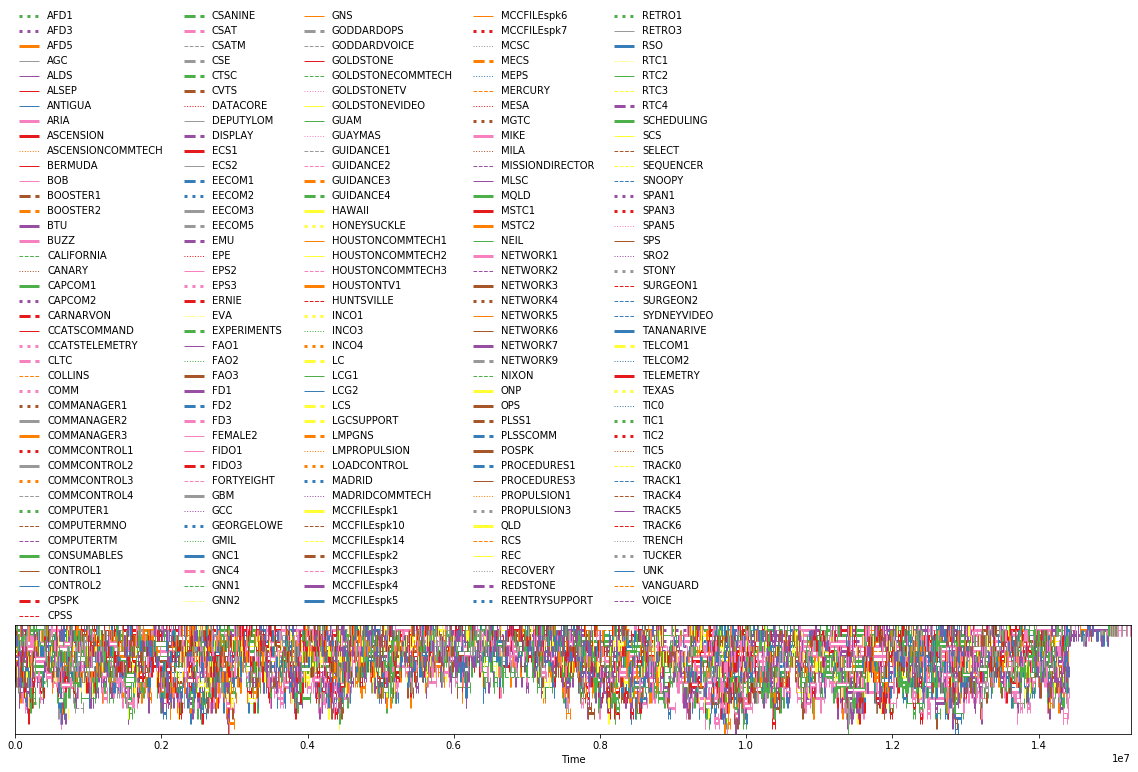

In [109]:
reference

# Output Annotations# 

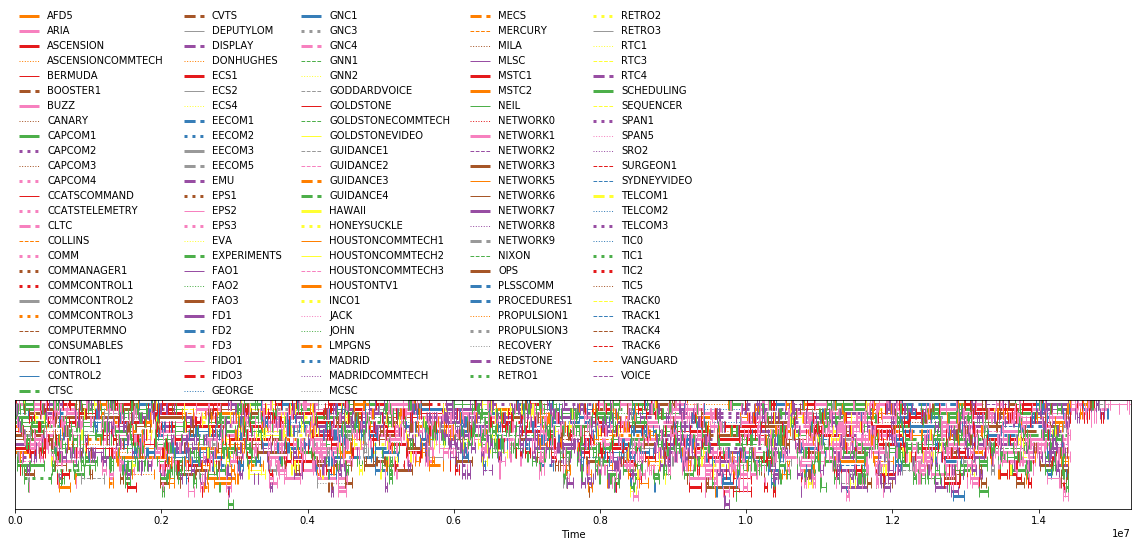

In [110]:
hypothesis

# DER for the Development Dataset

In [111]:
metric = DiarizationErrorRate()
metric(reference, hypothesis, detailed=True)

/net/home/dheerajpr/my_project/.venv/lib/python3.7/site-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


{'correct': 107626713.0,
 'confusion': 52711995.0,
 'total': 160696548.0,
 'missed detection': 357840.0,
 'false alarm': 38187772.0,
 'diarization error rate': 0.5678877868614826}

In [100]:
from pyannote.metrics.diarization import GreedyDiarizationErrorRate